# Dependencies

!pip install tensorflow opencv-python matplotlib 

import os
import cv2
import tensorflow as tf
import json 
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Create Dataset

## Select Images

In [23]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [24]:
images.as_numpy_iterator().next()

b'data/images/24_168d14de-f67c-11ef-9ecb-ee37f4c516a4.jpg'

In [25]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [26]:
images = images.map(load_image)

In [27]:
images.as_numpy_iterator().next()

array([[[128, 112,  99],
        [125, 109,  96],
        [125, 109,  96],
        ...,
        [ 97,  90,  74],
        [ 96,  89,  73],
        [100,  93,  77]],

       [[123, 107,  94],
        [126, 110,  97],
        [129, 113, 100],
        ...,
        [ 91,  84,  68],
        [ 95,  88,  72],
        [ 94,  87,  71]],

       [[128, 112,  97],
        [128, 112,  97],
        [128, 112,  97],
        ...,
        [ 93,  84,  69],
        [ 96,  87,  72],
        [ 90,  81,  66]],

       ...,

       [[143, 139, 127],
        [141, 137, 125],
        [142, 138, 126],
        ...,
        [178, 140, 121],
        [174, 133, 115],
        [175, 137, 118]],

       [[141, 137, 125],
        [141, 137, 125],
        [142, 138, 126],
        ...,
        [178, 137, 119],
        [176, 133, 116],
        [177, 136, 118]],

       [[141, 137, 125],
        [142, 138, 126],
        [141, 137, 125],
        ...,
        [172, 129, 112],
        [175, 132, 115],
        [168, 125, 108]]

In [28]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [38]:
image_generator = images.batch(4).as_numpy_iterator()

In [39]:
plot_images = image_generator.next()

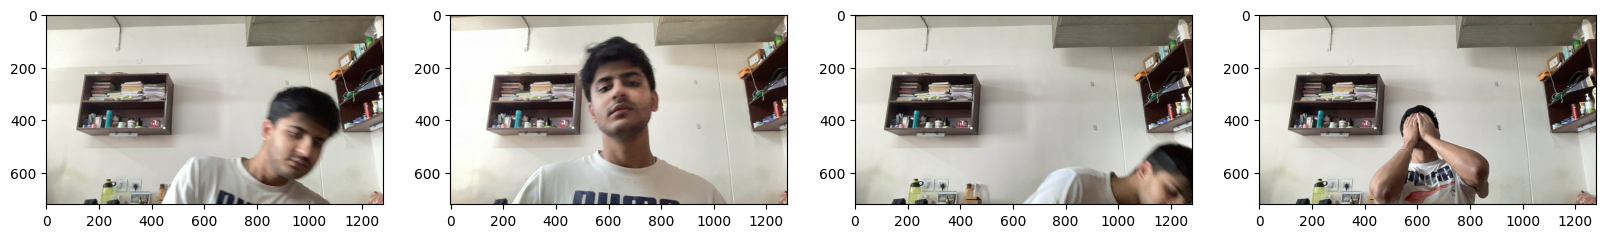

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## Split Data 

In [53]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        print(f"Checking for file: {existing_filepath}")   

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

Checking for file: data/labels/28_f798c10e-f67b-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/9_11c94cba-f67c-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/75f95744-f676-11ef-9ac5-ee37f4c516a4.json
Checking for file: data/labels/2_0f8f21cc-f67c-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/4_eff34ae6-f67b-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/2_ca8a3698-f67b-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/73a13494-f676-11ef-9ac5-ee37f4c516a4.json
Checking for file: data/labels/21_f55a655a-f67b-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/9_f18a6c18-f67b-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/28_d2ce1bbc-f67b-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/6_10d53d8c-f67c-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/27_d27c5be2-f67b-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/labels/18_cfa057c0-f67b-11ef-9ecb-ee37f4c516a4.json
Checking for file: data/

## Data Augmentation

In [79]:
import albumentations as alb

In [80]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [81]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='LeftEye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='RightEye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='LeftEye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='RightEye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['LeftEye','RightEye'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'LeftEye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'RightEye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

# Load Data

## Load Images

In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

2025-03-04 12:31:43.924105: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-04 12:31:43.924167: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-04 12:31:43.924185: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-04 12:31:43.924283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-04 12:31:43.924600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

## Prepare Labels

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [12]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [13]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

## View Samples

In [15]:
data_samples = train.as_numpy_iterator()

In [16]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


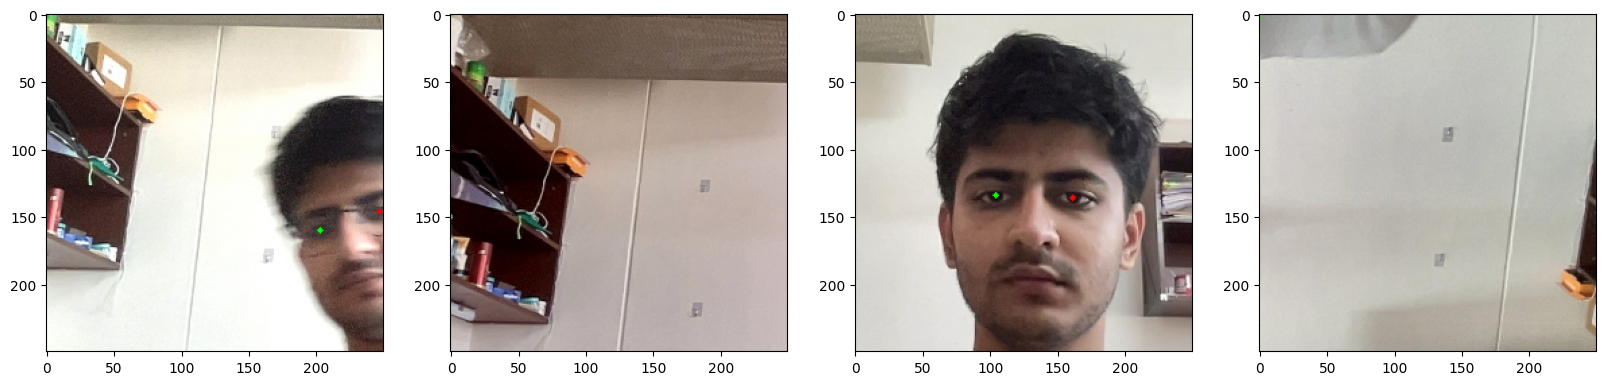

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255, 0, 0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0, 255, 0), -1)
    
    ax[idx].imshow(sample_image)


# Build Model

## Build the NN

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [19]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

## Setup Losses and Optimizer

In [21]:
from tensorflow.keras.optimizers.legacy import Adam

optimizer = Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [22]:
model.compile(optimizer, loss)

## Cross check Predictions

In [23]:
X, y = train.as_numpy_iterator().next()

In [24]:
X.shape

(16, 250, 250, 3)

In [25]:
coordinates = model.predict(X)

2025-03-04 12:32:17.822064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


In [26]:
coordinates

array([[-0.5025866 , -0.08811627, -0.10317765,  0.03279562],
       [-0.7881185 ,  0.27475882,  1.3043127 , -1.223727  ],
       [-0.86335796,  0.52950794,  0.8674859 ,  0.13658965],
       [ 0.23824123,  0.20098513,  0.6942196 , -0.06048283],
       [-0.1656856 ,  0.35401428,  1.4140584 , -1.1859466 ],
       [-0.81652784, -0.16439593,  0.32222506, -0.4700133 ],
       [-1.0885471 ,  0.588482  ,  0.8631317 ,  0.45161104],
       [-0.44206744,  0.29001653,  0.21001646, -0.77238023],
       [-0.25034553,  0.37715983,  0.9728985 , -0.80667686],
       [ 0.5181779 , -0.30257186,  1.1506984 , -0.37923545],
       [-0.41446817, -0.35667062, -0.06109047,  0.02079988],
       [ 0.07986528, -0.3073508 ,  0.84145606, -0.66662985],
       [-0.935475  ,  0.32468227,  0.8882821 , -0.7964684 ],
       [-0.07128477, -0.10176621,  0.5622859 , -0.3733268 ],
       [-0.46529126,  0.18454723,  0.44502124, -0.6614622 ],
       [-0.72591925, -0.03102678,  0.8122104 , -0.41753322]],
      dtype=float32)

## Train the model

In [27]:
# Train for 100 epochs
hist = model.fit(train, epochs=100, validation_data=val)

Epoch 1/2
500/500 [==============================] - 1709s 3s/step - loss: 0.2891 - val_loss: 0.0153
Epoch 2/2
500/500 [==============================] - 1599s 3s/step - loss: 0.0156 - val_loss: 0.0197


In [28]:
hist.history

{'loss': [0.2890540361404419, 0.015643585473299026],
 'val_loss': [0.015252092853188515, 0.019665593281388283]}

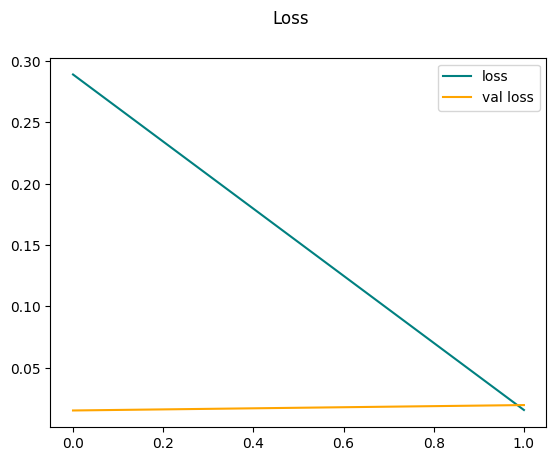

In [29]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()


## Making Predictions on the Test set

In [30]:
test_data = test.as_numpy_iterator()

In [37]:
test_sample = test_data.next()

In [38]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 0s 290ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


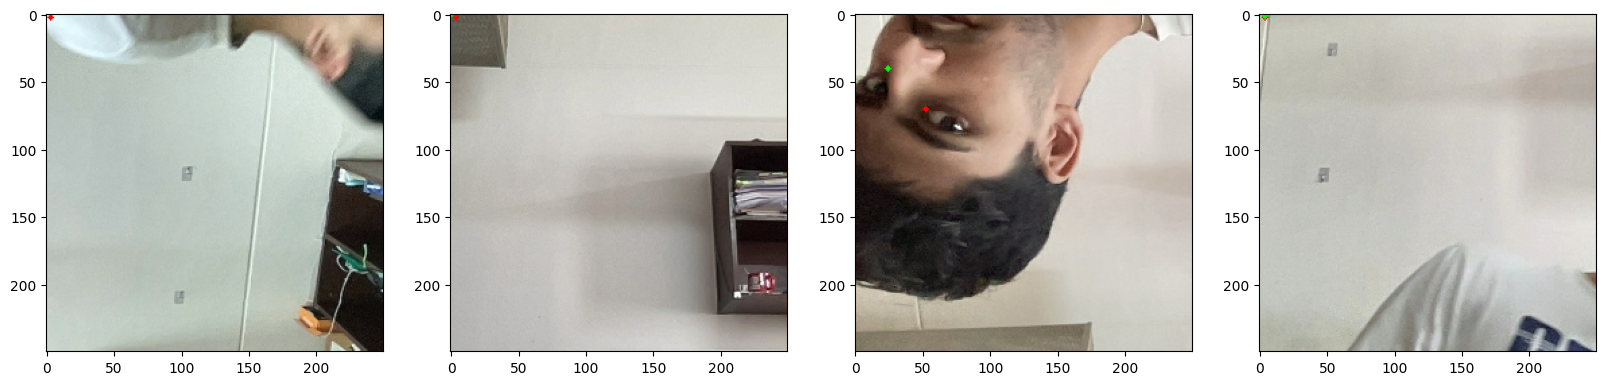

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # ✅ Make a writable copy
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

## Saving the model

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save('eyetrackerresnet.h5')

/Users/girirajpurohit23/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model = load_model('eyetrackerresnet.h5')

In [43]:
model.predict(test_sample[0])

1/1 [==============================] - 4s 4s/step


array([[ 1.3229424e-02,  8.4204562e-03, -7.8433501e-03, -4.4539659e-03],
       [ 1.9553792e-02,  1.0355787e-02,  3.2692319e-03,  3.0598012e-03],
       [ 2.1041545e-01,  2.8095484e-01,  9.9891342e-02,  1.6339521e-01],
       [ 1.9664245e-02,  9.2142560e-03,  1.6689595e-02,  4.3313210e-03],
       [ 1.3168044e-02,  5.4952092e-03,  1.5959252e-02,  9.7143336e-04],
       [ 1.3746578e-02,  2.0196848e-03,  1.2086545e-02,  2.7495495e-04],
       [ 1.5749453e-01,  2.8518197e-01,  9.0298310e-02,  2.4764736e-01],
       [ 1.0560719e-01,  1.3401252e-01,  7.9837561e-02,  1.1960118e-01],
       [ 5.3566700e-01,  7.1030641e-01,  6.4018154e-01,  6.6505539e-01],
       [ 1.6014224e-02,  3.4500957e-03,  2.2758055e-02,  1.5537514e-02],
       [ 4.8518696e-01,  4.5785773e-01,  3.4999540e-01,  5.1376140e-01],
       [ 3.0266246e-02,  2.1526771e-02,  1.8322142e-03,  2.5135991e-03],
       [ 2.4294834e-01,  4.4689539e-01,  3.4252578e-01,  4.5057011e-01],
       [ 9.5010653e-02,  4.3903813e-02,  7.5620539e

# Real time Tracking

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 55ms/step


2025-03-04 13:44:13.396 python3.11[14429:3280843] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-04 13:44:13.396 python3.11[14429:3280843] +[IMKInputSession subclass]: chose IMKInputSession_Modern


1/1 [==============================] - 0s 49ms/step
